In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from hyperopt import Trials, STATUS_OK, tpe
from hyperas.distributions import choice, uniform

2024-09-21 05:22:40.322837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 05:22:40.361055: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 05:22:40.395137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 05:22:40.395171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 05:22:40.396059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
input_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'END': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

placeholder_index = 4

In [3]:
def create_model(x_train, y_train, x_val, y_val, x_test, y_test):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(x_train.shape[1],)),
        keras.layers.Embedding(input_dim=21, input_length=10, output_dim=50),

        keras.layers.LSTM(128, return_sequences=True, input_shape=(10,21)),
        keras.layers.Dropout({{uniform(0, 0.8)}}),

        # keras.layers.LSTM(128, return_sequences=False),
        # keras.layers.Dropout({{uniform(0, 0.8)}}),

        keras.layers.Dense(64),
        # keras.layers.LeakyReLU(alpha={{uniform(0, 0.8)}}),

        keras.layers.Dropout({{uniform(0, 0.8)}}),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate={{choice([0.001, 0.005, 0.01, 0.05, 0.1])}}), loss='mean_squared_error', metrics=['mse'])

    result = model.fit(x_train, y_train, validation_split=0.3, epochs=200, batch_size={{choice([32, 64, 128, 5000])}}, verbose=2)

    mse = np.amax(result.history['val_mse']) 
    print('Best validation acc of epoch:', mse)
    return {'loss': -mse, 'status': STATUS_OK, 'model': model}

def data():
    x_train = pd.read_table('Data/20210524_A1101_xtrain.txt', sep=' ', header=None)
    y_train = pd.read_table('Data/20210524_A1101_ytrain.txt', sep=' ', header=None)
    x_val = pd.read_table('Data/20210524_A1101_xval.txt', sep=' ', header=None)
    y_val = pd.read_table('Data/20210524_A1101_yval.txt', sep=' ', header=None)
    x_test = pd.read_table('Data/20210524_A1101_xtest.txt', sep=' ', header=None)
    y_test = pd.read_table('Data/20210524_A1101_ytest.txt', sep=' ', header=None)
    return x_train, y_train, x_val, y_val, x_test, y_test
    

In [4]:
x_train = pd.read_table('Data/20210429_CRT_CCS_xtrain.txt', sep=' ', header=None)
y_train = pd.read_table('Data/20210429_CRT_CCS_ytrain.txt', sep=' ', header=None)
x_val = pd.read_table('Data/20210429_CRT_CCS_xval.txt', sep=' ', header=None)
y_val = pd.read_table('Data/20210429_CRT_CCS_yval.txt', sep=' ', header=None)
x_test = pd.read_table('Data/20210429_CRT_CCS_xtest.txt', sep=' ', header=None)
y_test = pd.read_table('Data/20210429_CRT_CCS_ytest.txt', sep=' ', header=None)

In [4]:
import keras_tuner as kt

class CCSTuner(kt.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential([
            keras.layers.Input(shape=(x_train.shape[1],)),
            keras.layers.Embedding(input_dim=21, input_length=10, output_dim=50),

            keras.layers.LSTM(128, return_sequences=False, input_shape=(10,21)),
            keras.layers.Dropout(hp.Float('dropout_1', 0, 0.8, step=0.00005)),

            # keras.layers.LSTM(128, return_sequences=False),
            # keras.layers.Dropout(hp.Float('dropout_2', 0, 0.8, step=0.00005)),

            keras.layers.Dense(64),
            # keras.layers.LeakyReLU(alpha=hp.Float('alpha_leaky', 0, 0.8, step=0.00005)),

            keras.layers.Dropout(hp.Float('dropout_3', 0, 0.8, step=0.00005)),
            keras.layers.Dense(1)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1])),
            loss='mean_squared_error',
            metrics=['mse']
        )

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', [32, 64, 128, 5000]),
            **kwargs
        )


In [5]:
tuner = kt.Hyperband(
    CCSTuner(),
    objective='val_mse',
    max_epochs=100,
    factor=3,
    directory='tuner',
    project_name='CCS_tuner'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [6]:
tuner.search(x_train, y_train, epochs=1000, validation_split=0.2, validation_data = (x_val, y_val), callbacks=[stop_early])

Trial 254 Complete [00h 03m 20s]
val_mse: 193.10557556152344

Best val_mse So Far: 181.06524658203125
Total elapsed time: 03h 08m 52s


In [7]:
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [9]:
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val))

Epoch 1/1000
1036/1036 [==============================] - 10s 9ms/step - loss: 299.2892 - mse: 299.2892 - val_loss: 186.6828 - val_mse: 186.6828
Epoch 2/1000
1036/1036 [==============================] - 9s 9ms/step - loss: 291.4583 - mse: 291.4583 - val_loss: 183.1220 - val_mse: 183.1220
Epoch 3/1000
1036/1036 [==============================] - 9s 8ms/step - loss: 281.8704 - mse: 281.8704 - val_loss: 180.9836 - val_mse: 180.9836
Epoch 4/1000
1036/1036 [==============================] - 8s 8ms/step - loss: 274.9377 - mse: 274.9377 - val_loss: 186.4657 - val_mse: 186.4657
Epoch 5/1000
1036/1036 [==============================] - 8s 8ms/step - loss: 266.9815 - mse: 266.9815 - val_loss: 180.5416 - val_mse: 180.5416
Epoch 6/1000
1036/1036 [==============================] - 9s 8ms/step - loss: 258.0006 - mse: 258.0006 - val_loss: 185.8258 - val_mse: 185.8258
Epoch 7/1000
1036/1036 [==============================] - 8s 8ms/step - loss: 253.6143 - mse: 253.6143 - val_loss: 203.7573 - val_mse: 

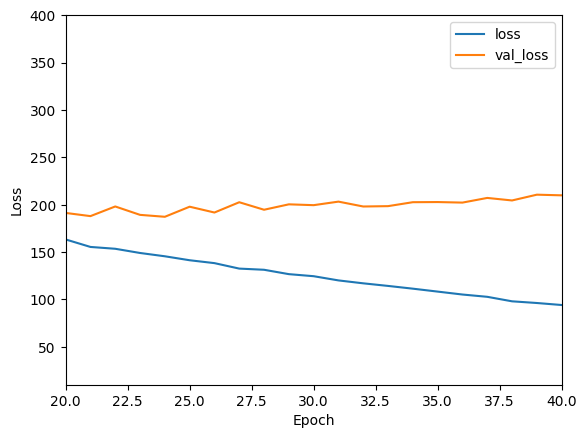

In [18]:
plt.plot(range(1000) ,history.history['loss'], label='loss')
plt.plot(range(1000), history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([10, 400])
plt.xlim([20, 40])
plt.legend(loc='best')
plt.show()

In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [11]:
tuner.get_best_hyperparameters()[0].values

{'dropout_1': 0.1572,
 'dropout_3': 0.004350000000000001,
 'learning_rate': 0.001,
 'batch_size': 64,
 'tuner/epochs': 34,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [ ]:
# model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
model.fit(x_train, y_train, epochs=best_epoch, validation_data=(x_val, y_val))

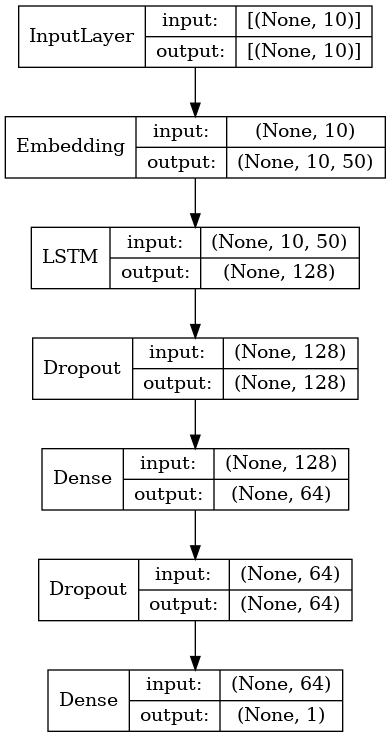

In [7]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

In [13]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test mse]:", eval_result)

144/144 [==============================] - 1s 3ms/step - loss: 213.3036 - mse: 213.3036
[test loss, test mse]: [213.30355834960938, 213.30355834960938]


In [25]:
y_pred = model.predict(x_test)
y_pred = pd.DataFrame(y_pred, index=x_test.index)
new_y_test = pd.DataFrame(y_test, index=x_test.index)

144/144 [==============================] - 2s 6ms/step


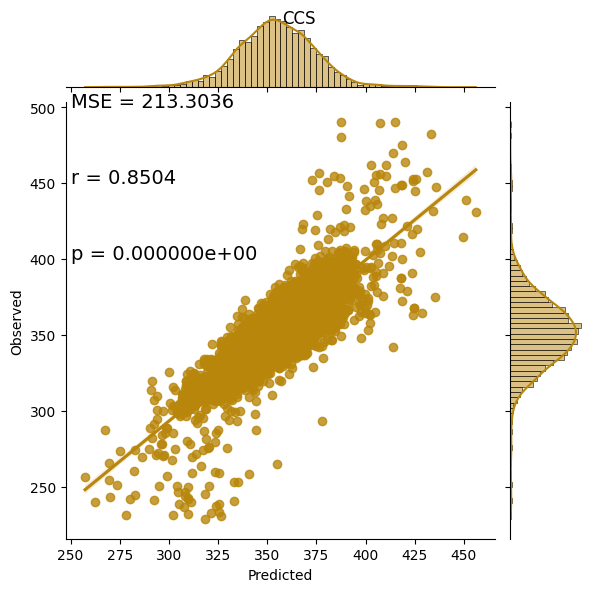

In [33]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

jp = sns.jointplot(x=y_pred.iloc[:, 0], y=new_y_test.iloc[:, 0], kind='reg', color='#B8860B')
jp.fig.suptitle('CCS')
jp.ax_joint.set_xlabel('Predicted')
jp.ax_joint.set_ylabel('Observed')
prCor, pCor = spearmanr(y_pred, new_y_test)
mse = round(mean_squared_error(y_pred, new_y_test),4)
jp.ax_joint.text(250, 500,"MSE = " + str(mse), fontsize=14)
jp.ax_joint.text(250,450,"r = " + str(round(prCor,4)), fontsize=14)
jp.ax_joint.text(250, 400,"p = " + "{:e}".format(pCor), fontsize=14)

# # Set the figure size
# jp.figure.set_size_inches(0.001, 0.25)

plt.savefig('Images/3_LSTM_CCS_perf.png')
plt.show()

# SHAP from here

In [5]:
import shap
shap.initjs()

In [10]:
samp = shap.kmeans(x_train, 100)
explainer = shap.KernelExplainer(model.predict, samp)
# shap_values = explainer.shap_values(X=x_test, nsamples=298, silent=True)

4/4 [==============================] - 0s 4ms/step


In [44]:
np.save('Reg_SHAP/CCS_shap_values.npy', shap_values)

QCHECIEHIR


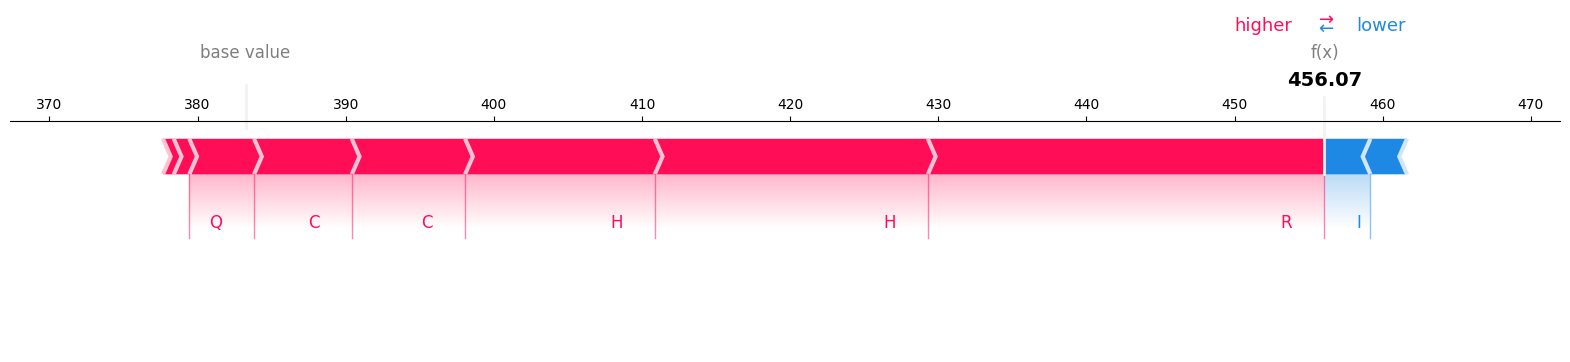

In [60]:
# Get top predicted and SHAP

top_y_pred_index = np.argmax(y_pred)

input_seq = [list(input_dict.keys())[int(key)] for key in x_test.iloc[top_y_pred_index]]
print(''.join([value if value != "END" else "" for value in input_seq]))

shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[top_y_pred_index][:, 0],
    features=input_seq,
    show=False,
    matplotlib=True
)

plt.savefig('Images/4_CCS_SHAP_top_pred.png')
plt.show()

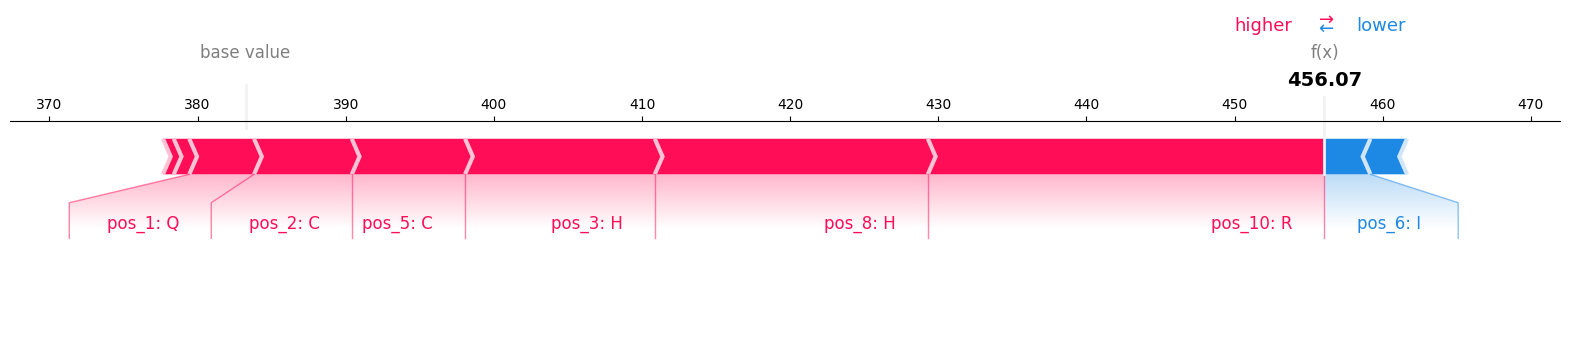

In [62]:
transformed_feature_values = [list(input_dict.keys())[int(value)] for value in x_test.iloc[top_y_pred_index].values]
feature_names_with_values = [
    f'pos_{i+1}: {transformed_feature_values[i]}' for i in range(len(transformed_feature_values))
]

shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[top_y_pred_index][:, 0],
    features=transformed_feature_values,
    feature_names=feature_names_with_values,
    show=False,
    matplotlib=True
)

plt.savefig('Images/4_CCS_PoSHAP_top_pred.png')
plt.show()

<Figure size 2000x600 with 0 Axes>

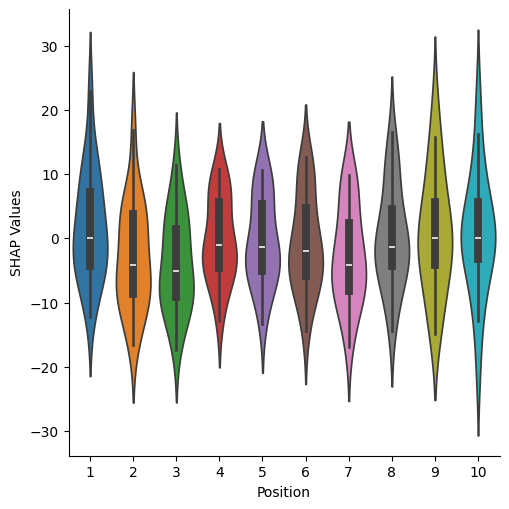

In [70]:
plt.figure(figsize=(20,6))
ax = sns.catplot(data=poshap_ccs, kind='violin')
ax.set_xlabels('Position')
ax.set_ylabels('SHAP Values')
ax.set_xticklabels([str(i+1) for i in range(10)])

plt.savefig('Images/6_CCS_catplot.png')
plt.show()

<Figure size 2000x600 with 0 Axes>

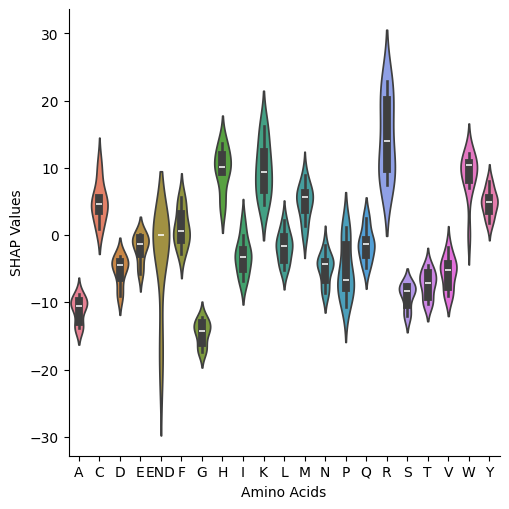

In [71]:
plt.figure(figsize=(20,6))
ax = sns.catplot(data=np.array(poshap_ccs), kind='violin')
ax.set_xlabels('Amino Acids')
ax.set_ylabels('SHAP Values')
ax.set_xticklabels([list(input_dict.keys())[int(key)] for key in range(21)])

plt.savefig('Images/7_CCS_AA_catplot.png')
plt.show()

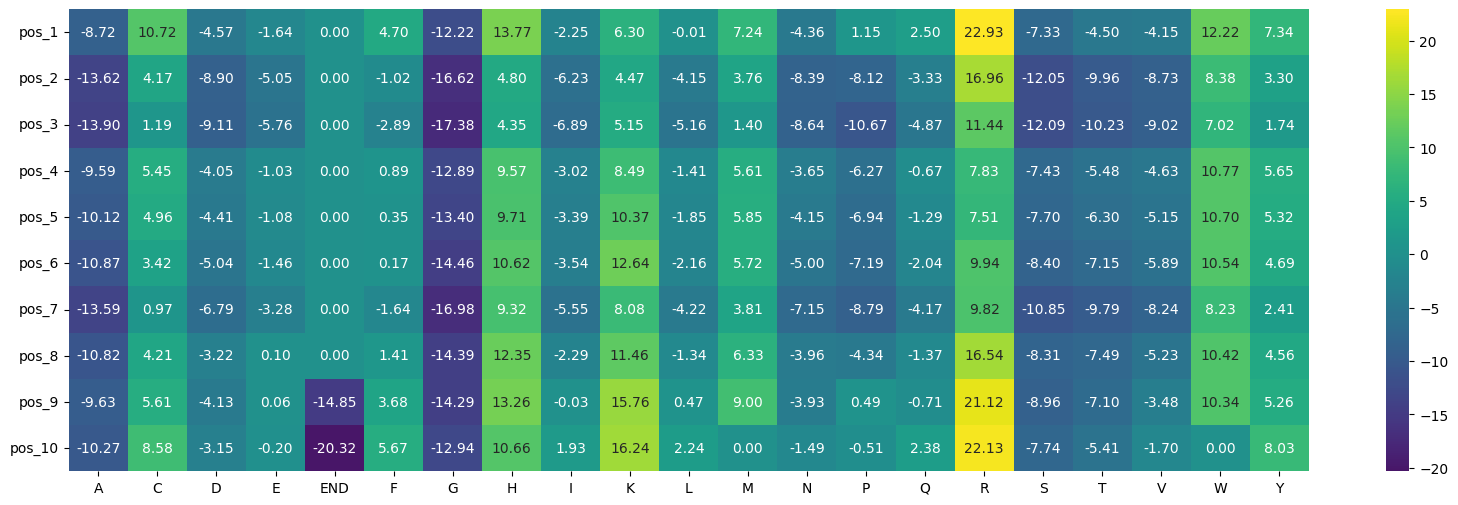

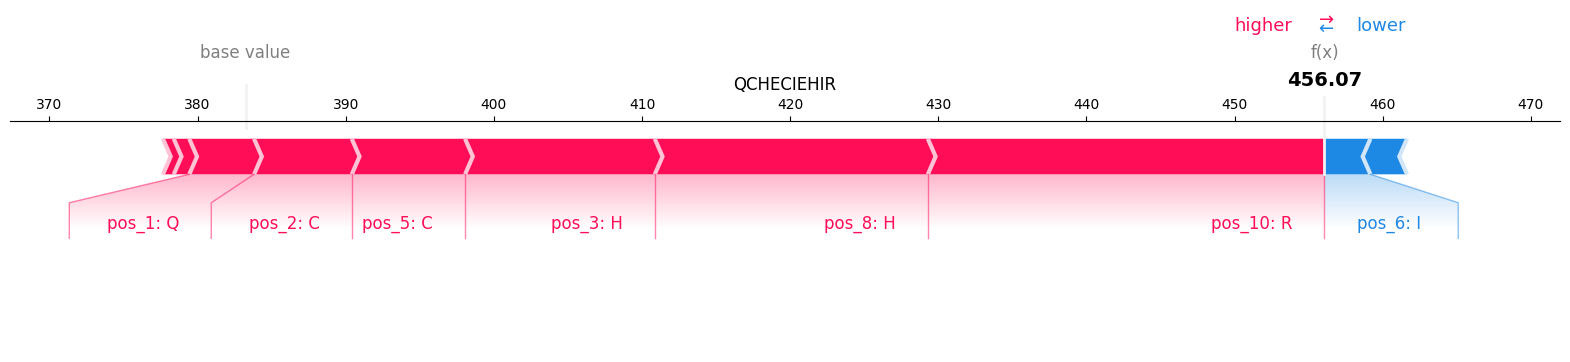

In [72]:
plt.figure(figsize=(20, 6))

# Heatmap
ax = sns.heatmap(poshap_ccs, cmap='viridis', center=0, annot=True, fmt= '.2f',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

# Top predicted force_plot
top_y_pred_index = np.argmax(y_pred)
input_seq = [list(input_dict.keys())[int(key)] for key in x_test.iloc[top_y_pred_index].values]
feature_names_with_values = [
    f'pos_{i+1}: {input_seq[i]}' for i in range(len(input_seq))
]
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[top_y_pred_index][:, 0],
    features=input_seq,
    feature_names=feature_names_with_values,
    show=False,
    matplotlib=True
)
ax2 = plt.gca()
ax2.set_title(''.join([value if value != "END" else "" for value in input_seq]))

plt.show()

# PoSHAP

In [ ]:
# Init pos array (3d)
pos = [[[0.0, 0] for _ in range(21)] for _ in range(10)]

# Start browsing through SHAP value
for i in range(x_test.shape[0]):
    input_array = [list(input_dict.keys())[int(key)] for key in x_test.iloc[i]]
    print(''.join([value if value != "END" else "" for value in input_array]))
    shap_values_single = explainer.shap_values(X=x_test.iloc[i : i + 1, :], nsamples=100)
    pos_index = 0
    for value in shap_values_single[0, :, 0]:
        pos[pos_index][input_dict.get(input_array[pos_index])][0] += value
        pos[pos_index][input_dict.get(input_array[pos_index])][1] += 1
        pos_index += 1

In [24]:
%%capture
# Recalculate PoSHAP for dependency analysis

pos = [[[] for _ in range(21)] for _ in range(10)]

for i in range(x_test.shape[0]):
    input_array = [list(input_dict.keys())[int(key)] for key in x_test.iloc[i]]
    shap_values_single = explainer.shap_values(X=x_test.iloc[i : i + 1, :], silent=True, nsamples=298)
    pos_index = 0
    for value in shap_values_single[0, :, 0]:
        pos[pos_index][input_dict.get(input_array[pos_index])].append(value)
        pos_index += 1

In [29]:
mean_pos = [[0.0 for _ in range(21)] for _ in range(10)]
count_pos = [[0 for _ in range(21)] for _ in range(10)]

for position in range(10):
    for aa in range(21):
        if len(pos[position][aa]) > 0:
            mean_pos[position][aa] = np.mean(pos[position][aa])
            count_pos[position][aa] = len(pos[position][aa])

In [105]:
count_trained_ccs = [[0 for _ in range(21)] for _ in range(10)]

for i in range(x_train.shape[0]):
    for index, value in enumerate(x_train.iloc[i]):
        count_trained_ccs[index][int(value)] += 1

# Saving model + poshap

In [32]:
model.save('Model/CCS_model')
np.save('Poshap/Spec_CCS_poshap', pd.DataFrame(pos).to_numpy())

INFO:tensorflow:Assets written to: Model/CCS_model/assets


INFO:tensorflow:Assets written to: Model/CCS_model/assets


# Test load model

In [24]:
model = keras.models.load_model('Model/CCS_model')
pos = np.load('Poshap/Spec_CCS_poshap.npy', allow_pickle=True)

In [100]:
poshap_ccs = [[np.mean(value) if len(value) > 0 else 0 for value in pos[i]] for i in range(10)]
count_ccs = [[len(value) for value in pos[i]] for i in range(10)]

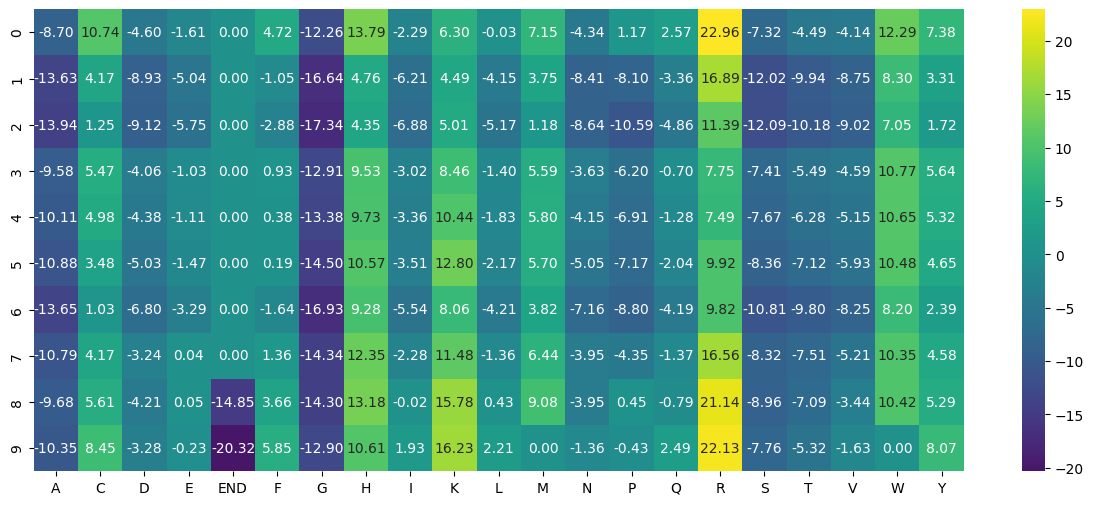

In [91]:
pd.DataFrame(poshap_ccs)

plt.figure(figsize=(15, 6))
ax = sns.heatmap(poshap_ccs, cmap='viridis', center=0, annot=True, fmt= '.2f')

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

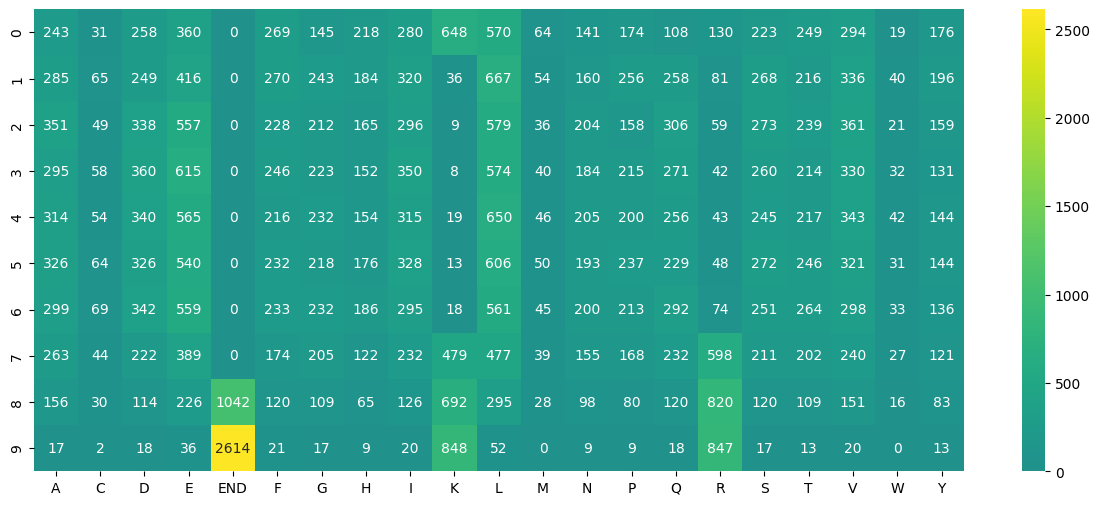

In [103]:
pd.DataFrame(count_ccs)

plt.figure(figsize=(15, 6))
ax = sns.heatmap(count_ccs, cmap='viridis', center=0, annot=True, fmt= 'd',)

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

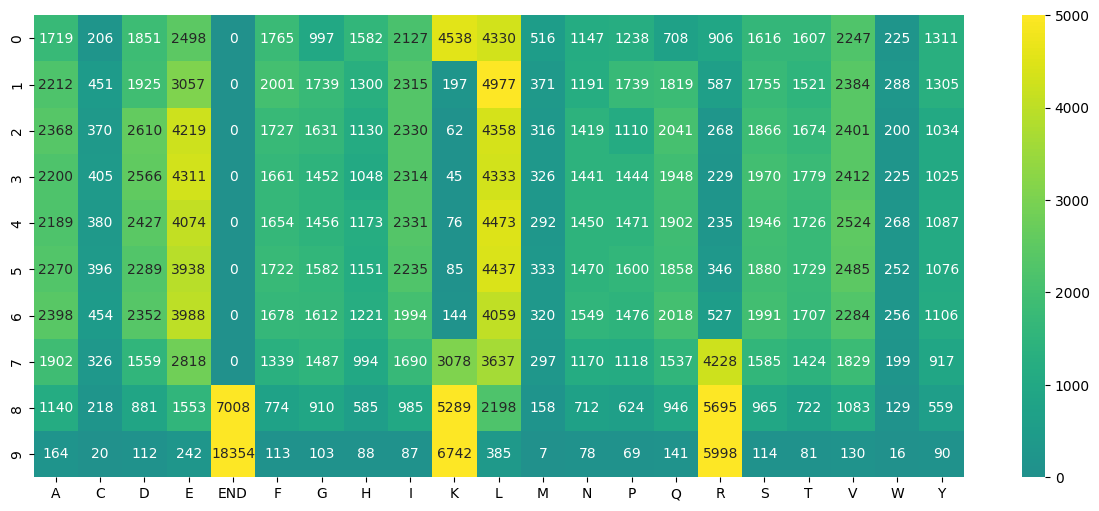

In [123]:
plt.figure(figsize=(15, 6))
ax = sns.heatmap(count_trained_ccs, cmap='viridis', center=0, annot=True, fmt= 'd', vmax=5000)

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

In [124]:
y_train_for_reg = y_train.copy()
y_train_for_reg = y_train_for_reg.rename(columns={0: 'prediction'})
y_train_for_reg['rank'] = y_train_for_reg['prediction'].rank(ascending=False)

In [125]:
# Extract to top value

import statsmodels.api as sm

X = sm.add_constant(y_train_for_reg['rank'])
y = y_train_for_reg['prediction']

model = sm.OLS(y, X).fit()

intercept, slope = model.params
top_y_train = pd.DataFrame()

y_train_sorted = y_train_for_reg.sort_values(by='rank')
for i, index in enumerate(y_train_sorted['rank'].index):
    if (i*slope + intercept) <= y_train_sorted['prediction'][index]:
        top_y_train = pd.concat([top_y_train, y_train_sorted.loc[index:index]])
    else:
        break

In [128]:
top_ccs_x = pd.DataFrame(x_train.to_numpy()[top_y_train.index])

top_count_trained_ccs = [[0 for _ in range(21)] for _ in range(10)]

for i in range(top_ccs_x.shape[0]):
    for index, value in enumerate(top_ccs_x.iloc[i]):
        top_count_trained_ccs[index][int(value)] += 1

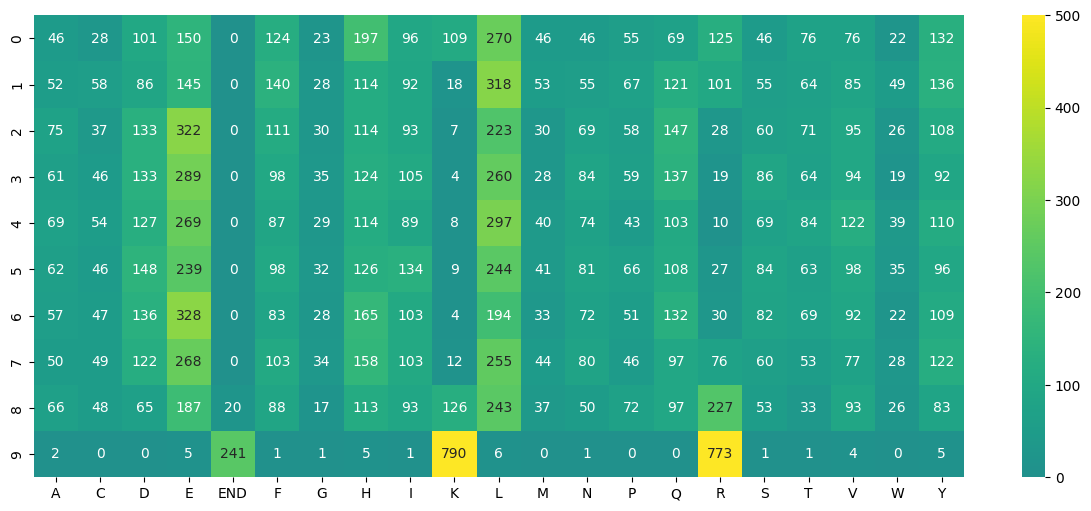

In [131]:
plt.figure(figsize=(15, 6))
ax = sns.heatmap(top_count_trained_ccs, cmap='viridis', center=0, annot=True, fmt= 'd', vmax=500)

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

# Linear Regression to get Top values

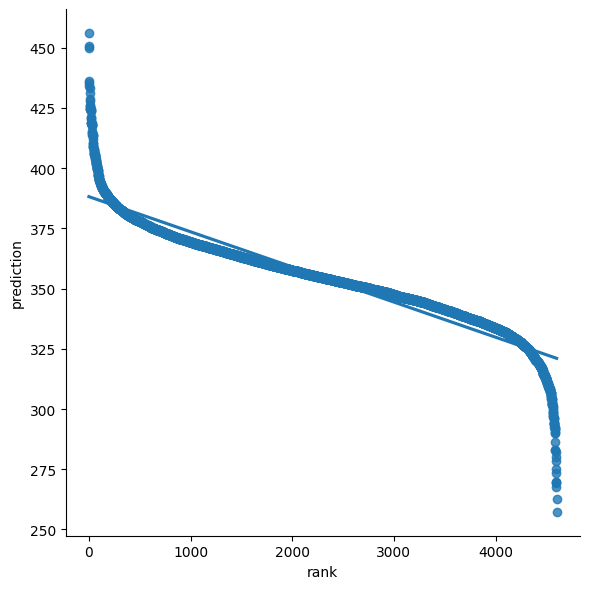

In [21]:
# Rank the output prediction and plot linear regression

y_pred_for_reg = y_pred.copy()
y_pred_for_reg = y_pred_for_reg.rename(columns={0: 'prediction'})
y_pred_for_reg['rank'] = y_pred_for_reg['prediction'].rank(ascending=False)

sns.lmplot(x='rank', y='prediction', data=y_pred_for_reg, fit_reg=True, height=6, ci=None)
plt.savefig('Images/8_CCS_Linear_top_predicted.png')

In [ ]:
y_pred_sorted = y_pred_for_reg.sort_values(by='rank')

prediction    0.865849
rank          6.000000
Name: 115, dtype: float64

In [14]:
# Extract to top value

import statsmodels.api as sm

X = sm.add_constant(y_pred_for_reg['rank'])
y = y_pred_for_reg['prediction']

model = sm.OLS(y, X).fit()

intercept, slope = model.params
top_y_pred = pd.DataFrame()

y_pred_sorted = y_pred_for_reg.sort_values(by='rank')
for i, index in enumerate(y_pred_sorted['rank'].index):
    if (i*slope + intercept) <= y_pred_sorted['prediction'][index]:
        top_y_pred = pd.concat([top_y_pred, y_pred_sorted.loc[index:index]])
    else:
        break

In [17]:
top_shap_values = shap_values[top_y_pred.index]
top_poshap = [[[0.0, 0] for _ in range(21)] for _ in range(10)]
for i in range(top_shap_values.shape[0]):
    pos_index = 0
    for value in top_shap_values[i, :, 0]:
        input_array = [list(input_dict.keys())[int(key)] for key in x_test.iloc[i]]
        top_poshap[pos_index][input_dict.get(input_array[pos_index])][0] += value
        top_poshap[pos_index][input_dict.get(input_array[pos_index])][1] += 1
        pos_index += 1

top_poshap_ccs = [[value[0]/(value[1] if value[1] != 0 else 1) for value in top_poshap[i]] for i in range(10)]
top_count_ccs = [[value[1] for value in top_poshap[i]] for i in range(10)]

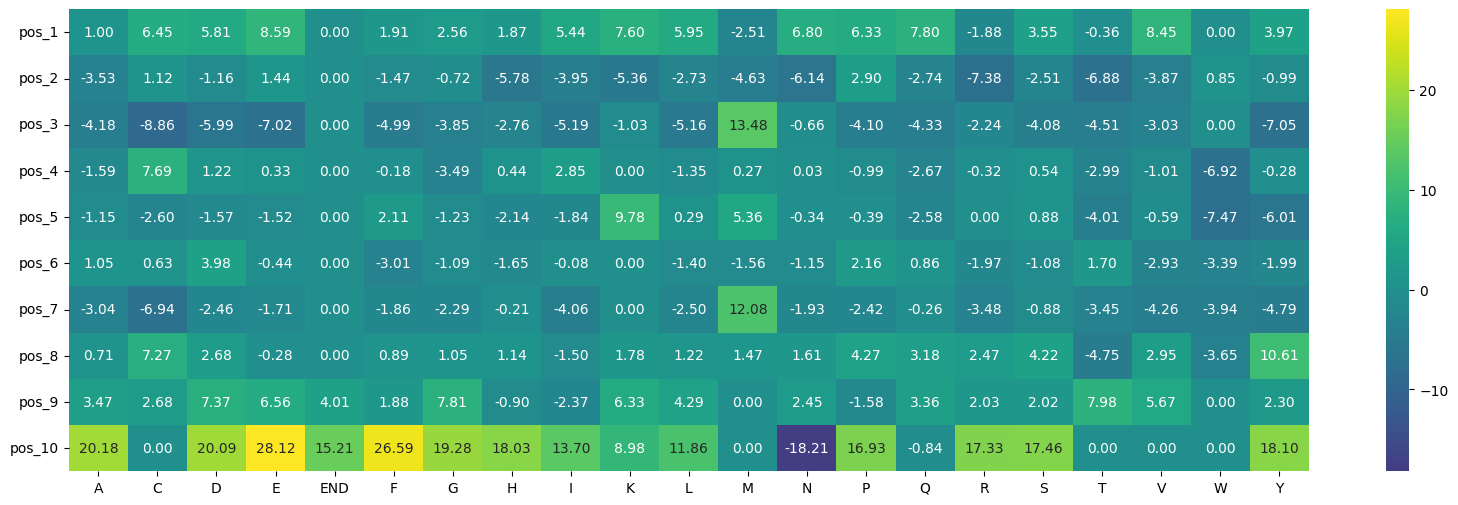

In [22]:
# Show heatmap of top predicted value
plt.figure(figsize=(20, 6))

ax = sns.heatmap(top_poshap_ccs, cmap='viridis', center=0, annot=True, fmt= '.2f',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

plt.savefig('Images/8_CCS_Linear_top_predicted_poshap.png')
plt.show()

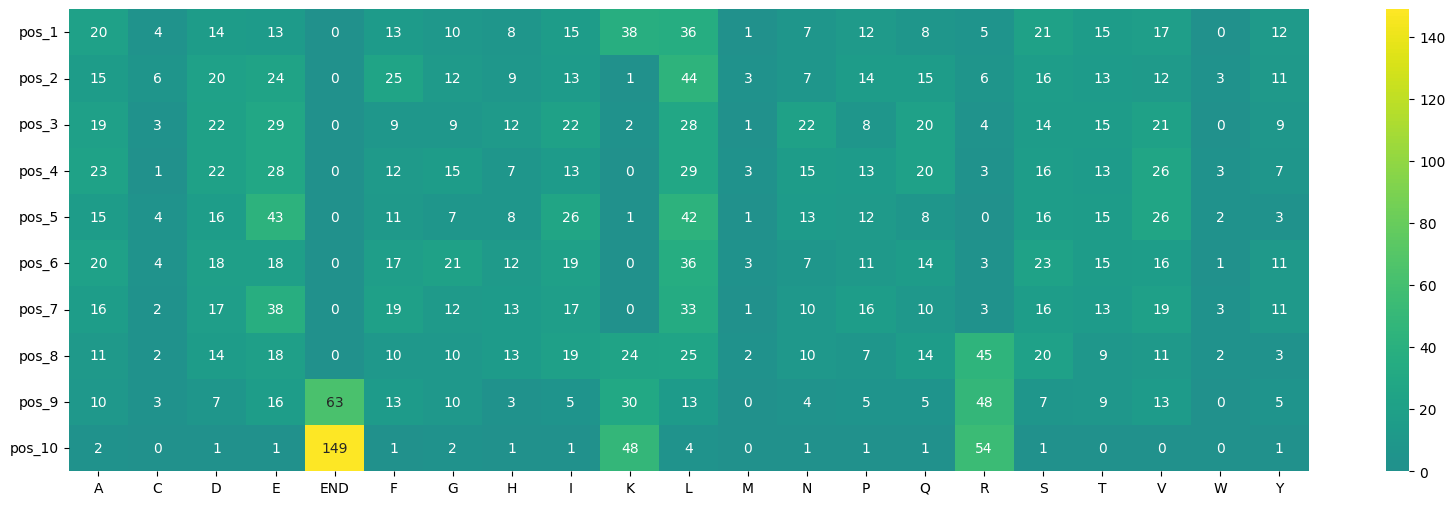

In [23]:
# Show heatmap of top predicted value
plt.figure(figsize=(20, 6))

ax = sns.heatmap(top_count_ccs, cmap='viridis', center=0, annot=True, fmt= 'd',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

plt.savefig('Images/8_CCS_Linear_top_predicted_count.png')
plt.show()

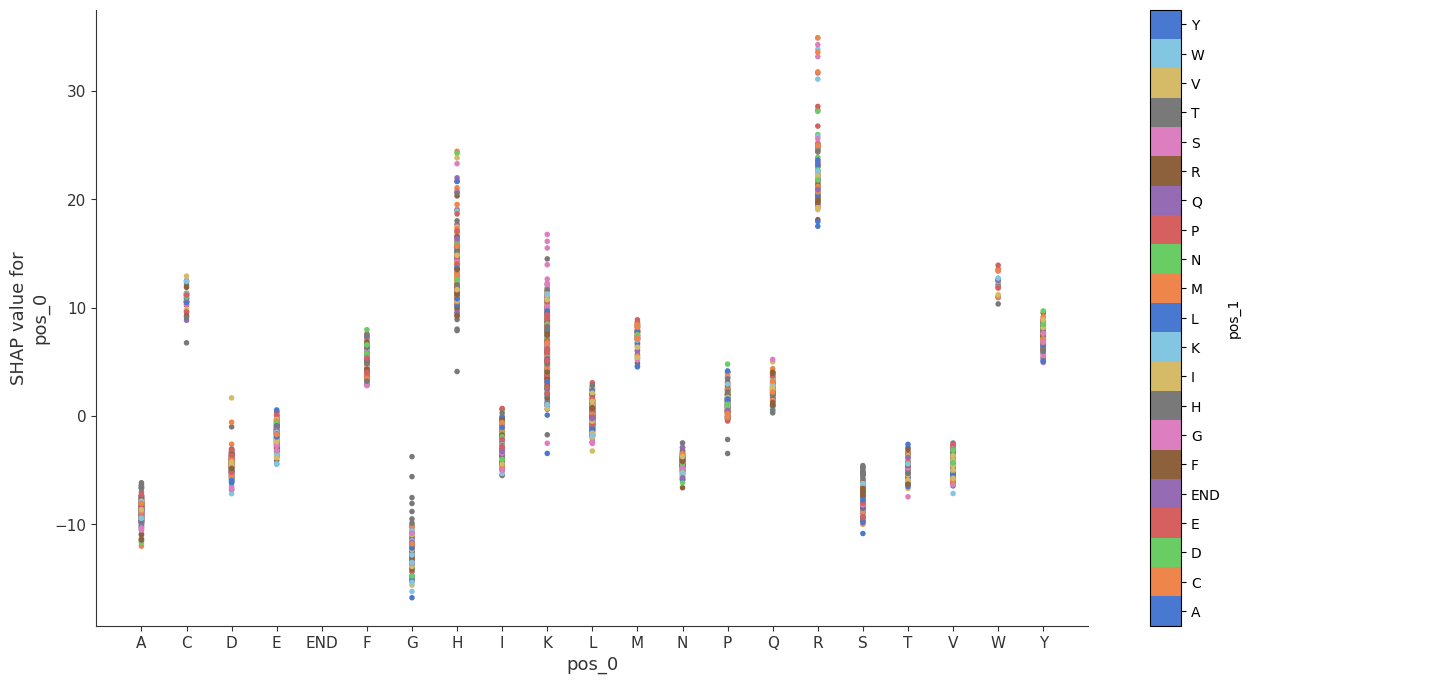

In [97]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors

base = 0
interactions = 1

colors = sns.color_palette("muted", 21)
custom_cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(20, 8))
shap.dependence_plot(base, shap_values[:, : , 0], x_test.iloc[:,:], interaction_index=interactions, ax = ax, show=False, cmap=custom_cmap, feature_names=['pos_' + str(i) for i in range(10)])
ax.set_xticks(range(len(input_dict.keys())))
ax.set_xticklabels(list(input_dict.keys()))

cbar = ax.figure.axes[1]
cbar.clear()
cbar.set_axis_off()

norm = mcolors.BoundaryNorm(boundaries=np.arange(22) - 0.5, ncolors=custom_cmap.N)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax, orientation='vertical')
cbar.set_ticks(range(len(input_dict.keys())))
cbar.set_ticklabels(list(input_dict.keys()))
cbar.minorticks_off()
cbar.set_label('pos_' + str(interactions))

plt.show()

# Get interdependence report

In [37]:
shap_values = np.load('Reg_SHAP/CCS_shap_values.npy')

In [10]:
# Dependency analysis


# Divide 2 group

first_aa = [[[[[] for _ in range(10)] for _ in range(21)] for _ in range(21)] for _ in range(10)]
compare_aa = [[[[[] for _ in range(10)] for _ in range(21)] for _ in range(21)] for _ in range(10)]

for f_pos in range(10):
    for f_aa in range(21):
        if f_aa != placeholder_index:   
            for c_pos in range(10):
                if f_pos != c_pos:
                    for c_aa in range(21):
                        if c_aa != placeholder_index:
                            for i in range(x_test.shape[0]):
                                if x_test.iloc[i, f_pos] == f_aa and x_test.iloc[i, c_pos] == c_aa:
                                    first_aa[f_pos][f_aa][c_aa][c_pos].append(shap_values[i, f_pos, 0])
                                if x_test.iloc[i, f_pos] == f_aa and x_test.iloc[i, c_pos] != c_aa:
                                    compare_aa[f_pos][f_aa][c_aa][c_pos].append(shap_values[i, f_pos, 0])
                        

In [14]:
np.save('Dep/CCS_firstdep.npy', pd.DataFrame(first_aa).to_numpy())
np.save('Dep/CCS_comdep.npy', pd.DataFrame(compare_aa).to_numpy())

In [132]:
first_aa = np.load('Dep/CCS_firstdep.npy', allow_pickle=True)
compare_aa = np.load('Dep/CCS_comdep.npy', allow_pickle=True)

In [137]:
from scipy.stats import mannwhitneyu

output = []

for f_pos in range(len(first_aa)):
    for f_aa in range(len(first_aa[f_pos])):
        for c_aa in range(len(first_aa[f_pos][f_aa])):
            for c_pos in range(len(first_aa[f_pos][f_aa][c_aa])):
                try:
                    stat, test = mannwhitneyu(first_aa[f_pos][f_aa][c_aa][c_pos], compare_aa[f_pos][f_aa][c_aa][c_pos])
                except ValueError:
                    stat = 1
                    test = 1
                if test < 1 and test > 0:
                    output.append([test, list(input_dict.keys())[f_aa], f_pos + 1, c_pos + 1, list(input_dict.keys())[c_aa], len(first_aa[f_pos][f_aa][c_aa][c_pos]), len(compare_aa[f_pos][f_aa][c_aa][c_pos]), np.mean(first_aa[f_pos][f_aa][c_aa][c_pos]) - np.mean(compare_aa[f_pos][f_aa][c_aa][c_pos])])
                    


/tmp/ipykernel_1029/774111497.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, test = mannwhitneyu(first_aa[f_pos][f_aa][c_aa][c_pos], compare_aa[f_pos][f_aa][c_aa][c_pos])


In [138]:
output = pd.DataFrame(output, columns=['p-val', 'aa', 'pos', 'compare pos', 'compare aa', 'compare size', 'total size', 'absolute mean shap'])

In [139]:
from statsmodels.stats import multitest
corr_pval = multitest.multipletests(output['p-val'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
output.insert(1, 'corr p-val', corr_pval[1])
output

,p-val,corr p-val,aa,pos,compare pos,compare aa,compare size,total size,absolute mean shap
0,0.656267,1.0,A,1,2,A,24,219,-0.031779
1,0.340478,1.0,A,1,3,A,28,215,-0.176799
2,0.287078,1.0,A,1,4,A,11,232,0.282715
3,0.561058,1.0,A,1,5,A,25,218,-0.018373
4,0.195317,1.0,A,1,6,A,15,228,0.337345
...,...,...,...,...,...,...,...,...,...
28760,0.641026,1.0,Y,10,9,V,2,11,-0.146274
28761,0.923077,1.0,Y,10,5,W,1,12,0.129621
28762,0.153846,1.0,Y,10,3,Y,1,12,-1.328506
28763,0.769231,1.0,Y,10,4,Y,1,12,-0.044383


In [140]:
output_below = output.loc[output['corr p-val'] <= 0.05]
output_below.sort_values(by='corr p-val', ascending=True)

,p-val,corr p-val,aa,pos,compare pos,compare aa,compare size,total size,absolute mean shap
7468,4.134671e-32,1.189338e-27,L,3,1,K,85,494,1.983215
6590,1.568136e-31,4.510744e-27,E,3,1,K,115,442,1.745266
6651,8.036719e-26,2.311762e-21,E,3,10,R,105,452,-1.942840
1493,9.096364e-23,2.616569e-18,L,1,10,R,137,433,-0.896563
4420,3.914772e-20,1.126084e-15,L,2,1,K,83,584,1.329584
...,...,...,...,...,...,...,...,...,...
7816,1.595324e-06,4.588948e-02,N,3,10,R,40,164,-1.098207
3833,1.624416e-06,4.672631e-02,G,2,3,L,30,213,1.240788
4190,1.674632e-06,4.817080e-02,I,2,1,R,8,312,-2.503372
13990,1.721689e-06,4.952438e-02,P,5,4,R,6,194,2.014783


In [142]:
output_below['distance'] = abs(output_below['pos'] - output_below['compare pos'])

/tmp/ipykernel_1029/946419605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_below['distance'] = abs(output_below['pos'] - output_below['compare pos'])


In [156]:
kind_dict = {'A': 'Hydrophobic', 'C': 'Hydrophobic', 'D': 'Negative', 'E': 'Negative', 'END': 'End', 'F': 'Hydrophobic', 'G': 'Hydrophobic', 'H': 'Positive', 'I': 'Hydrophobic', 'K': 'Positive', 'L': 'Hydrophobic', 'M': 'Hydrophobic', 'N': 'Polar',
 'P': 'Hydrophobic', 'Q': 'Polar', 'R': 'Positive', 'S': 'Polar', 'T': 'Polar', 'V': 'Hydrophobic', 'W': 'Hydrophobic', 'Y': 'Hydrophobic'}

In [163]:
def determine_kind(row):
    aa_kind = kind_dict[row['aa']]
    compare_aa_kind = kind_dict[row['compare aa']]
    
    if aa_kind == compare_aa_kind and (aa_kind == 'Positive' or aa_kind == 'Negative'):
        return 'Charge Repulsion'
    elif (aa_kind == 'Positive' and compare_aa_kind == 'Negative') or (aa_kind == 'Negative' and compare_aa_kind == 'Positive'):
        return 'Charge Attraction'
    elif (aa_kind == 'Polar' or compare_aa_kind == 'Polar') and (aa_kind == 'Positive' or compare_aa_kind == 'Positive' or aa_kind == 'Negative' or compare_aa_kind == 'Negative'):
        return 'Polar'
    else:
        return 'Other'

In [164]:
output_below['kind'] = output_below.apply(determine_kind, axis=1)

/tmp/ipykernel_1029/1100127124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_below['kind'] = output_below.apply(determine_kind, axis=1)


In [185]:
def determine_kind_distance(row):
    kind = row['kind']
    if row['distance'] == 1:
        return kind + '-Neighbor'
    elif 2 <= row['distance'] <= 6:
        return kind + '-Near'
    else:
        return kind + '-Far'

In [186]:
output_below['kind-distance'] = output_below.apply(determine_kind_distance, axis=1)

/tmp/ipykernel_1029/4038680031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_below['kind-distance'] = output_below.apply(determine_kind_distance, axis=1)


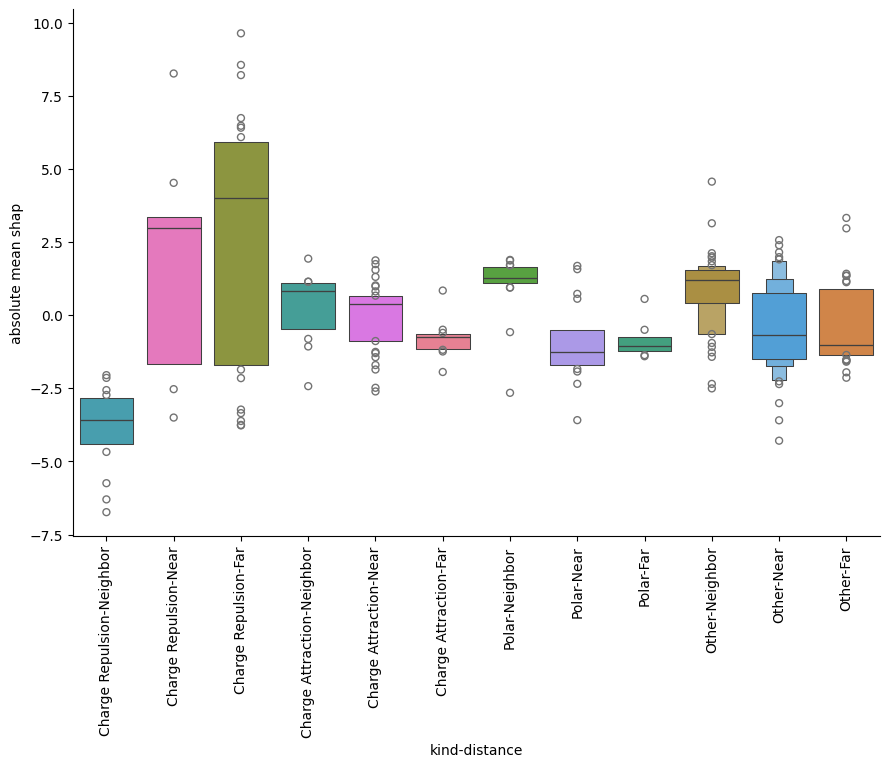

In [190]:
ax = sns.catplot(data=output_below, x='kind-distance', y='absolute mean shap', kind='boxen', legend=False, hue='kind-distance', palette='husl', height=6, aspect=1.5,
                 order=[
                     'Charge Repulsion-Neighbor', 'Charge Repulsion-Near', 'Charge Repulsion-Far',
                        'Charge Attraction-Neighbor', 'Charge Attraction-Near', 'Charge Attraction-Far',
                        'Polar-Neighbor', 'Polar-Near', 'Polar-Far',
                        'Other-Neighbor', 'Other-Near', 'Other-Far'
                 ])
ax.set_xticklabels(rotation=90)
plt.show()

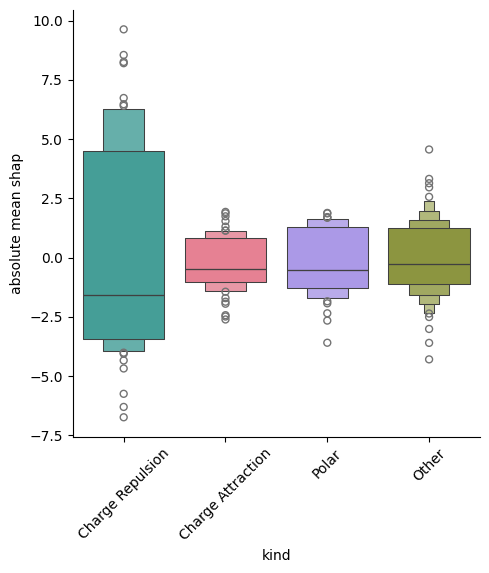

In [174]:
ax = sns.catplot(data=output_below, x='kind', y='absolute mean shap', kind='boxen', legend=False, hue='kind', palette='husl', order=['Charge Repulsion', 'Charge Attraction', 'Polar', 'Other'])
ax.set_xticklabels(rotation=45)

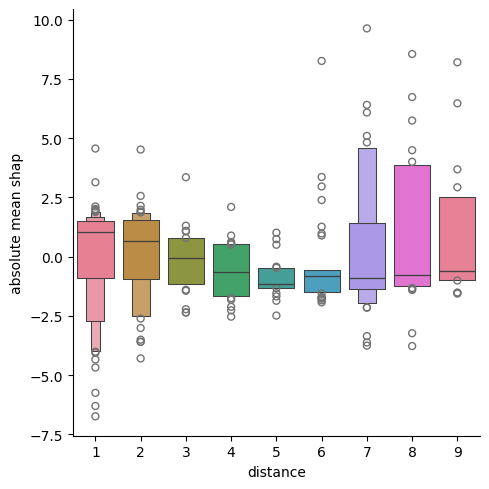

In [155]:
sns.catplot(data=output_below, x='distance', y='absolute mean shap', kind='boxen', legend=False, hue='distance', palette='husl')